In [1]:
import Pkg
Pkg.activate("../../Tasks2D")

  Activating project at `~/Developer/research/summer2023/tasks2d/Tasks2D`


In [2]:
using Revise

In [3]:
using Plots

In [4]:
import LineWorlds
const L = LineWorlds

LineWorlds

In [5]:
ps = [
    L.Pose([0, 0], π/2),
    L.Pose([0, 1], π/4),
    L.Pose([100, 100], 2π/2),
    L.Pose([100, 100], π/4)
]

4-element Vector{LineWorlds.Pose}:
 LineWorlds.Pose([0.0, 0.0], 1.5707963267948966)
 LineWorlds.Pose([0.0, 1.0], 0.7853981633974483)
 LineWorlds.Pose([100.0, 100.0], 3.141592653589793)
 LineWorlds.Pose([100.0, 100.0], 0.7853981633974483)

In [6]:
env = L.load_env();

In [7]:
_segs, _boxes, _bb, _center, _xs, _hds, _ps, _dxs, _dhds, _us, _T = env;

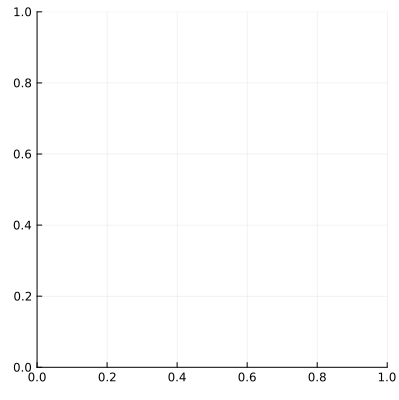

In [8]:
mypl = plot(size=(400,400), aspect_ration=:equal)

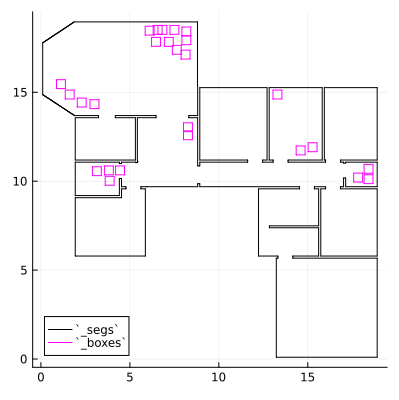

In [9]:
plot!(_segs, c=:black, label="`_segs`")
plot!(_boxes, c=:magenta, label="`_boxes`")

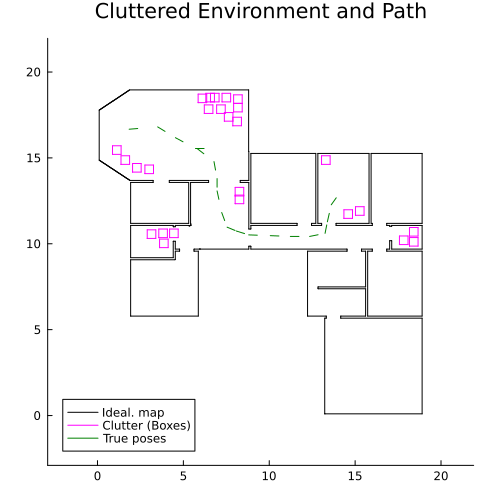

In [10]:
mypl = plot(size=(500,500), aspect_ratio=:equal, title="Cluttered Environment and Path", grid=false,
xlim=(_bb[1][1]-3, _bb[2][1]+3),
ylim=(_bb[1][2]-3, _bb[2][2]+3),
legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
plot!(_boxes, c=:magenta, label="Clutter (Boxes)")
plot!(_ps[[1]], c=:green, linewidth=1, label="True poses")
plot!(_ps[2:end], c=:green, linewidth=1, label=nothing)

In [11]:
(dists, as, ys) = L.create_observations(_ps, _segs, 2π, 100, .2);

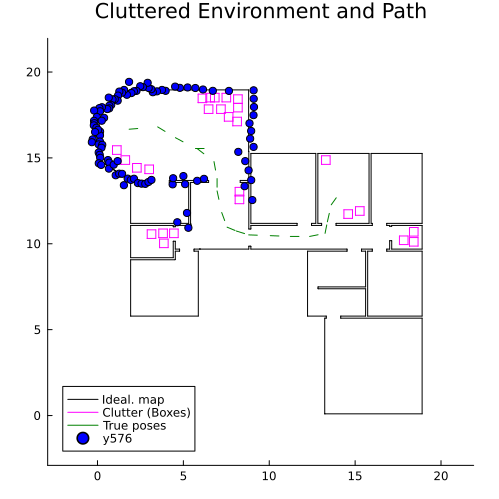

In [12]:
mypl = plot(size=(500,500), aspect_ratio=:equal, title="Cluttered Environment and Path", grid=false,
xlim=(_bb[1][1]-3, _bb[2][1]+3),
ylim=(_bb[1][2]-3, _bb[2][2]+3),
legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
plot!(_boxes, c=:magenta, label="Clutter (Boxes)")
plot!(_ps[[1]], c=:green, linewidth=1, label="True poses")
plot!(_ps[2:end], c=:green, linewidth=1, label=nothing)

scatter!(ys[1] .* _ps[1], c=:blue)

In [13]:
using Random
# -----------------------
ani = Animation()
for t=1:1:_T
    p = _ps[t]
    y = ys[t]

    agent_plt = plot(
        size=(500,500), aspect_ratio=:equal, title="Given Sensor Observations", grid=false,
        xlim=(_bb[1][1]-3, _bb[2][1]+3),
        ylim=(_bb[1][2]-3, _bb[2][2]+3),
        legend=:bottomleft,
    )
    plot!(_segs, c=:black, linewidth=1, label=nothing)
    plot!(_boxes, c=:magenta, label=nothing)
    plot!([p], c=:red, r=1.0, linewidth=2, label=nothing)
    scatter!([p.x], c=:red, label="Pose `_ps[t]`")
    scatter!(Random.shuffle(y[1:2:end]).*p, c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Obs in pose coords `_ys[t].*_ps[t]`")

    frame(ani, agent_plt)
end
# gif(ani, "_imgs/loc_data_gen.gif", fps=2) # gif(ani, fname, fps=10)
gif(ani, fps=3)

LoadError: UndefVarError: `col` not defined

In [14]:
# -----------------------
myplts = []
ani = Animation()
for t=1:1:_T
    p = _ps[t]
    y = ys[t]
    
    ego_plt = plot(
        size=(300,300), aspect_ratio=:equal, grid=false,
        xlim=(-10,10),
        ylim=(-10,10),
        legend=:bottomleft,
    )
    plot!([L.Pose()], c=:red, r=1.0, linewidth=2, label=nothing)
    scatter!([zeros(2)], c=:red, markerstrokewidth=0, label=nothing)
    scatter!(shuffle(y[1:2:end]), c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Sensor Obs.")

    frame(ani, plot(ego_plt, layout=grid(1, 1), size=(700,500), plot_title="Task input available to the Agent",  grid=false))
end
gif(ani, "loc_task_input.gif", fps=2) # gif(ani, fname, fps=10)

LoadError: UndefVarError: `col` not defined

In [15]:
# using BenchmarkTools
# @btime (dists, as, ys) = L.create_observations([_ps[1]], _segs, 2π, 100, .2);

In [16]:
# @btime L.create_observations_GPU([_ps[1]], _segs, 2π, 100, .2);

In [76]:
stacked = L.stack(Vector.(_segs))
@time L.cast(ps[1], L.create_angles(2π, 10_000), stacked);

  0.064337 seconds (29.65 k allocations: 263.915 MiB, 11.42% gc time)


In [18]:
# p_ = (Float32.(Vector(ps[1])))
# a_ = L.MtlVector(Float32.(L.create_angles(2π, 10000)))
# s_ = L.MtlArray(Float32.(stacked))
# @btime L.cast_GPU(p_, a_, s_);

In [19]:
# @btime L.cast_GPU(p_, a_, s_);

In [20]:
using Metal

In [21]:
p_ = Float32.(Vector(ps[1]))

3-element Vector{Float32}:
 0.0
 0.0
 1.5707964

In [112]:
a_ = MtlVector{Float32}(L.create_angles(2π, 100_000));

In [113]:
s_ = MtlArray{Float32}(L.stack(Vector.(_segs)));

In [120]:
v0 = p_; as = a_; segs = s_;

In [119]:
@time L.cast_GPU(v0, as, segs);
# vals = Tuple{MtlVector, MtlVector}[]
# @time begin
# z
#         push!(vals, L.cast_GPU(v0, as, segs));
#     end
# end

  0.006692 seconds (8.54 k allocations: 647.797 KiB)


In [98]:
vals[1][1]

100000-element MtlVector{Float32}:
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
  ⋮
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf

In [47]:
segs_ = segs;

In [27]:
@time as_   = (as .+ v0[3]);

  4.905634 seconds (6.14 M allocations: 410.968 MiB, 1.87% gc time, 99.30% compilation time: 5% of which was recompilation)


In [28]:
@time x_ = MtlVector(v0[1:2]);
@time x′_ = cat(v0[1] .+ cos.(as_), v0[2] .+ sin.(as_), dims=2);
@time y_  = view(segs_,:,1:2);
@time y′_ = view(segs_,:,3:4);

  0.015237 seconds (18.34 k allocations: 1.206 MiB, 93.60% compilation time)
  0.831430 seconds (2.43 M allocations: 163.554 MiB, 6.47% gc time, 94.37% compilation time)
  0.013148 seconds (40.58 k allocations: 2.740 MiB, 99.73% compilation time)
  0.000005 seconds (5 allocations: 224 bytes)


In [29]:
@time begin
    x_  = reshape(x_ , :, 1, 2)
    x′_ = reshape(x′_, :, 1, 2)
    y_  = reshape(y_ , 1, :, 2)
    y′_ = reshape(y′_, 1, :, 2)
end;

  0.103799 seconds (370.27 k allocations: 24.755 MiB, 11.99% gc time, 99.71% compilation time)


In [30]:
@time s_, t_, _, _ = L.intersections(x_, x′_, y_, y′_);

  2.059530 seconds (6.71 M allocations: 437.033 MiB, 7.39% gc time, 90.46% compilation time)


In [31]:
x, x′, y, y′ = x_, x′_, y_, y′_;

In [32]:
@time begin
    n = ndims(x)
    dx = x′ .- x
    dy = y′ .- y
    v  = x .- y
end;

  0.069239 seconds (28.55 k allocations: 1.543 MiB, 98.56% compilation time)


In [33]:
@time begin
    dx1 = selectdim(dx, n, 1)
    dx2 = selectdim(dx, n, 2)
    dy1 = selectdim(dy, n, 1)
    dy2 = selectdim(dy, n, 2)
    v1 = selectdim(v, n, 1)
    v2 = selectdim(v, n, 2)
end;

  0.004206 seconds (182 allocations: 9.000 KiB, 99.32% compilation time)


In [34]:
@time begin
   a, b = -dx1, dy1
    c, d = -dx2, dy2
    
    det = a.*d .- b.*c

end;

  0.047858 seconds (25.67 k allocations: 1.415 MiB, 98.29% compilation time)


In [35]:
@time begin
    s = 1 ./det .*(  d.*v1 .- b.*v2)
    t = 1 ./det .*(- c.*v1 .+ a.*v2)
end;

  0.116735 seconds (52.21 k allocations: 2.868 MiB, 99.06% compilation time)
